<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import os

import numpy as np
from torchvision import datasets, models
from torch import nn, optim
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import skimage.io
import gdown
from skimage.transform import resize
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# !conda list
# np.__version__

In [3]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
# Download some attributes
# !gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y
# lfw_attributes.txt downloaded

In [5]:
def fetch_dataset(
    attrs_name="lfw_attributes.txt",
    images_name="lfw-deepfunneled",
    dx=80,
    dy=80,
    dimx=64,
    dimy=64,
):
    # download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    # read attrs
    df_attrs = pd.read_csv(
        "lfw_attributes.txt",
        sep="\t",
        skiprows=1,
    )
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace("_", " ").split()
                person_id = " ".join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append(
                    {"person": person_id, "imagenum": photo_number, "photo_path": fpath}
                )

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=("person", "imagenum"))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # image preprocessing
    all_photos = (
        df["photo_path"]
        .apply(skimage.io.imread)
        .apply(lambda img: img[dy:-dy, dx:-dx])
        .apply(lambda img: resize(img, [dimx, dimy]))
    )

    all_photos = np.stack(all_photos.values)  # .astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

In [7]:
data.shape, attrs.shape

((13143, 64, 64, 3), (13143, 73))

In [8]:
data = data.transpose(0, 3, 1, 2)  # reshaping to get [batch_size, 3, 64, 64] for Conv2d
data.shape

(13143, 3, 64, 64)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [10]:
sample = data[0][0, :, :]
sample.shape, sample.min(), sample.max()

((64, 64), 0.03046320919596628, 0.9334490531701385)

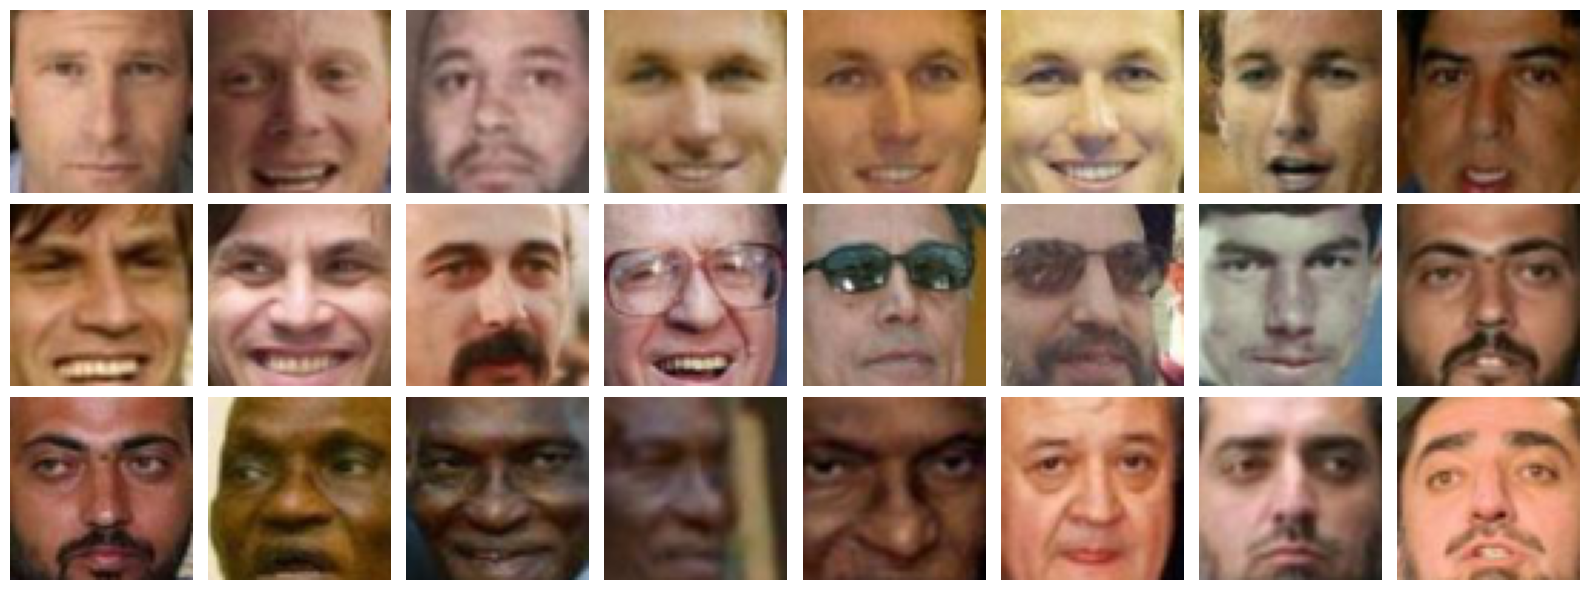

In [11]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 8, figsize=(16, 6), tight_layout=True)
for i in range(3):
    for j in range(8):
        idx = i * 8 + j
        smiling_image = data[idx].transpose([1, 2, 0])
        axes[i, j].imshow(smiling_image)
        axes[i, j].axis("off")

plt.show();

In [12]:
tensor_data = torch.from_numpy(data).float()  # .to(device)
train_data, val_data = torch.utils.data.random_split(tensor_data, [0.8, 0.2])

In [13]:
assert len(train_data) + len(val_data) == len(tensor_data)

len(train_data), len(val_data)

(10515, 2628)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

напомню, что автоэнкодер выглядит вот так:

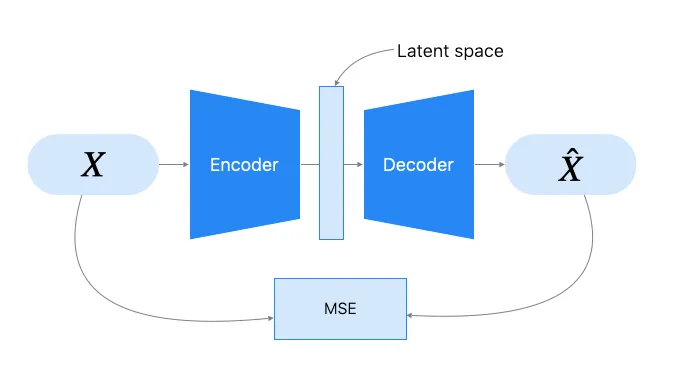

In [14]:
latent_space_dim = 256

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, latent_space_dim=latent_space_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_space_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 64 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (128, 64, 64)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):
        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return latent_code, reconstruction

In [16]:
"""
Этот лосс, использующий оценку схожести карт признаков с помощью VGG16 в итоге
не понадобился, т.к. работает очень долго на моей машине. 

Оставляю на будущее и для наглядности.
"""


class PerceptualLoss(nn.Module):
    def __init__(self, vgg_part=0.1):
        super().__init__()
        self.vgg = (
            models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features[:29].eval()
        )
        self.vgg_part = vgg_part

    def forward(self, x, y):
        features_x = self.vgg(x)
        features_y = self.vgg(y)
        mse_loss = F.mse_loss(x, y)
        features_loss = F.mse_loss(features_x, features_y)

        return mse_loss + self.vgg_part * features_loss

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [17]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

In [18]:
model = Autoencoder().to(device)

In [19]:
# criterion = PerceptualLoss(vgg_part=0.01).to(device)
criterion = nn.MSELoss().to(device)

In [22]:
BEST_MODEL_PATH = "best_autoencoder.pt"
print(f"Using device: {device}")

n_epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
best_loss = float("inf")
best_epoch = 0
latent_codes = []
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for X_batch in train_loader:
        X_batch = X_batch.to(device)
        latent_code, output = model(X_batch)
        train_loss = criterion(output, X_batch)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses_per_epoch.append(train_loss.item())
        latent_codes.append(latent_code)

    epoch_train_loss = sum(train_losses_per_epoch)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            latent_code, output = model(X_batch)
            val_loss = criterion(output, X_batch)
            val_losses_per_epoch.append(val_loss.item())
            latent_codes.append(latent_code)

    epoch_val_loss = sum(val_losses_per_epoch)
    val_losses.append(epoch_val_loss)
    scheduler.step()

    print(f"\n{epoch=}\ntrain_loss: {epoch_train_loss:.4f}\tval_loss: {epoch_val_loss:.4f}")
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_epoch = epoch
        torch.save(model, BEST_MODEL_PATH)
        print(f"New loss minimum: {best_loss}, model params saved.")

Using device: mps


  0%|          | 0/10 [00:00<?, ?it/s]


epoch=0
train_loss: 4.4934	val_loss: 0.9909
New loss minimum: 0.9908528439700603, model params saved.

epoch=1
train_loss: 3.6737	val_loss: 0.9327
New loss minimum: 0.9326727110892534, model params saved.

epoch=2
train_loss: 3.5453	val_loss: 0.9063
New loss minimum: 0.906278507784009, model params saved.

epoch=3
train_loss: 3.3709	val_loss: 0.8779
New loss minimum: 0.877888678573072, model params saved.

epoch=4
train_loss: 3.1880	val_loss: 0.8112
New loss minimum: 0.8112493706867099, model params saved.

epoch=5
train_loss: 3.0489	val_loss: 0.7968
New loss minimum: 0.7967803105711937, model params saved.

epoch=6
train_loss: 2.9858	val_loss: 0.7964
New loss minimum: 0.7964282529428601, model params saved.

epoch=7
train_loss: 2.9079	val_loss: 0.7670
New loss minimum: 0.7670431388542056, model params saved.

epoch=8
train_loss: 2.7907	val_loss: 0.7636
New loss minimum: 0.7636294709518552, model params saved.

epoch=9
train_loss: 2.7155	val_loss: 0.7454
New loss minimum: 0.7453945945

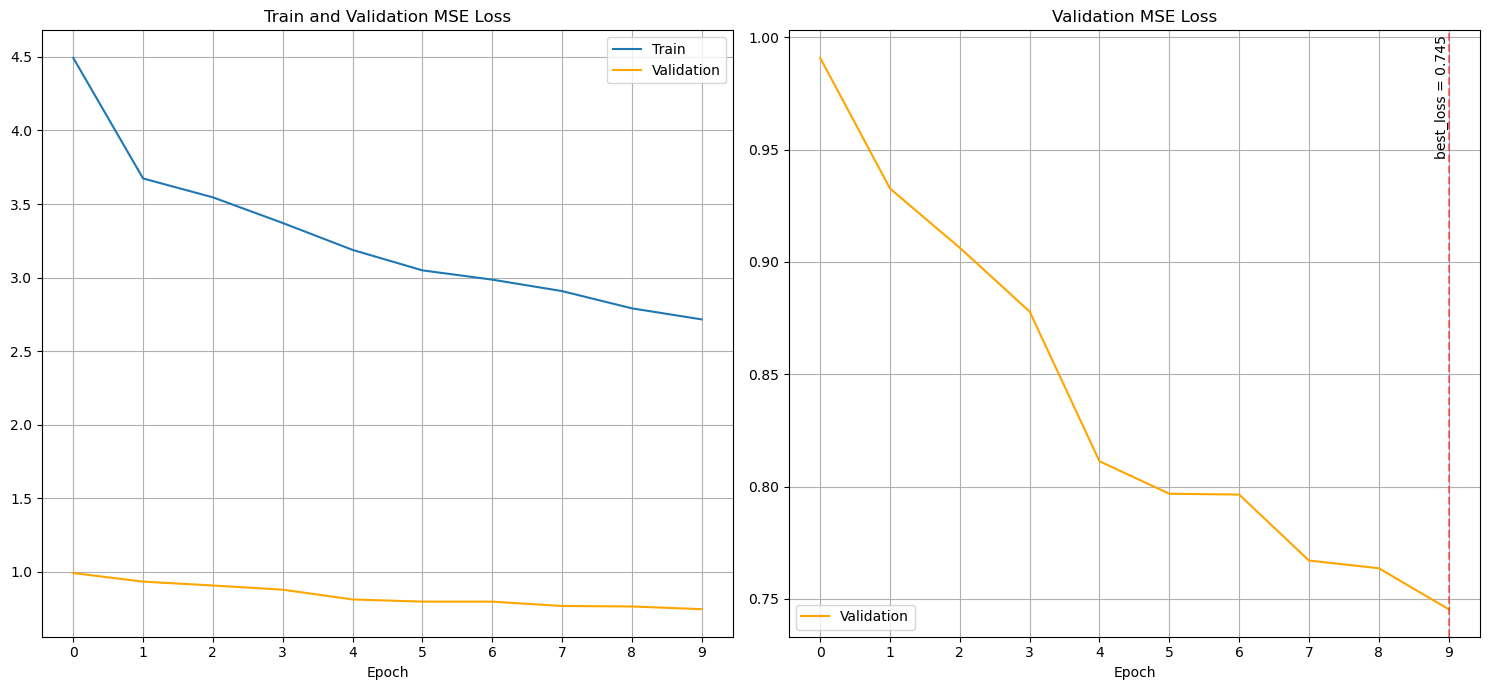

In [45]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15, 7))

val_plot_data = np.arange(len(val_losses)), val_losses

# Left plot: both losses
plt.subplot(121)
plt.plot(np.arange(len(train_losses)), train_losses, label="Train")
plt.plot(*val_plot_data, color="orange", label="Validation")
plt.xlabel("Epoch")
plt.title("Train and Validation MSE Loss")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.legend()

# Right plot: validation only
plt.subplot(122)
plt.plot(*val_plot_data, color="orange", label="Validation")
plt.axvline(best_epoch, color="red", linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    plt.ylim()[1],
    f"{best_loss = :.3f} ",
    rotation=90,
    horizontalalignment="right",
    verticalalignment="top",
)
plt.xlabel("Epoch")
plt.title("Validation MSE Loss")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [20]:
val_data[0].permute(1, 2, 0).shape

torch.Size([64, 64, 3])

In [21]:
model = torch.load(BEST_MODEL_PATH, weights_only=False)
model.eval();

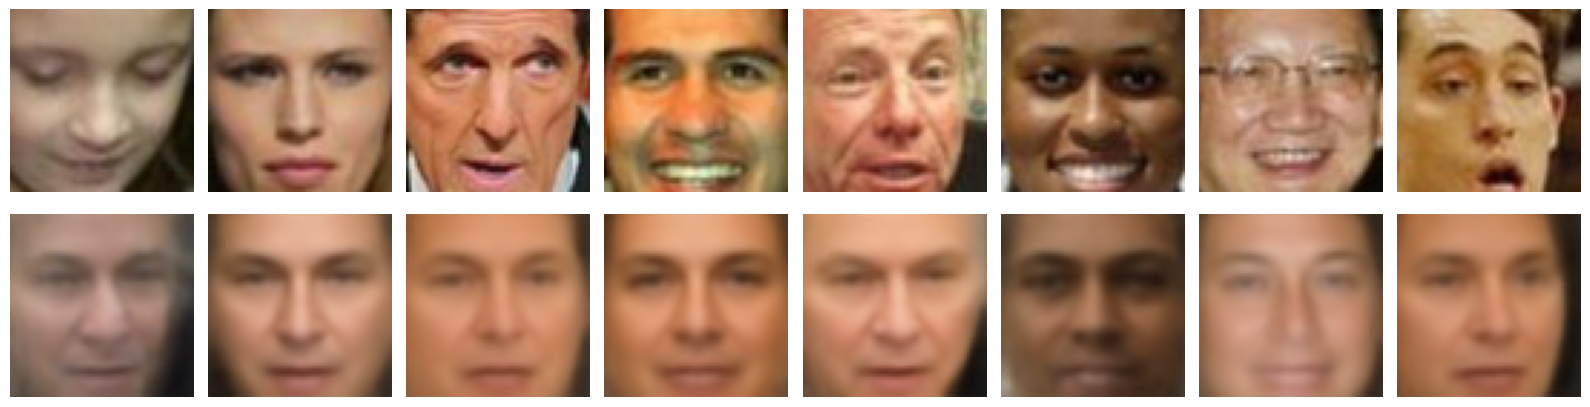

In [22]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 8, figsize=(16, 4.5), tight_layout=True)
for j in range(8):
    image_data = val_data[-j]
    image = image_data.permute(1, 2, 0)
    axes[0, j].imshow(image.numpy())
    axes[0, j].axis("off")
    latent = image_data.unsqueeze(0).to(device)
    latent, output = model(latent)
    output = output.squeeze().permute(1, 2, 0).cpu().detach()
    axes[1, j].imshow(output)
    axes[1, j].axis("off")

plt.show();

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [23]:
latent_space = torch.vstack(latent_codes)
latent_mean = latent_space.mean()
latent_std = latent_space.std()
latent_space.shape, latent_mean, latent_std

(torch.Size([262860, 256]),
 tensor(-0.0035, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.1147, device='mps:0', grad_fn=<StdBackward0>))

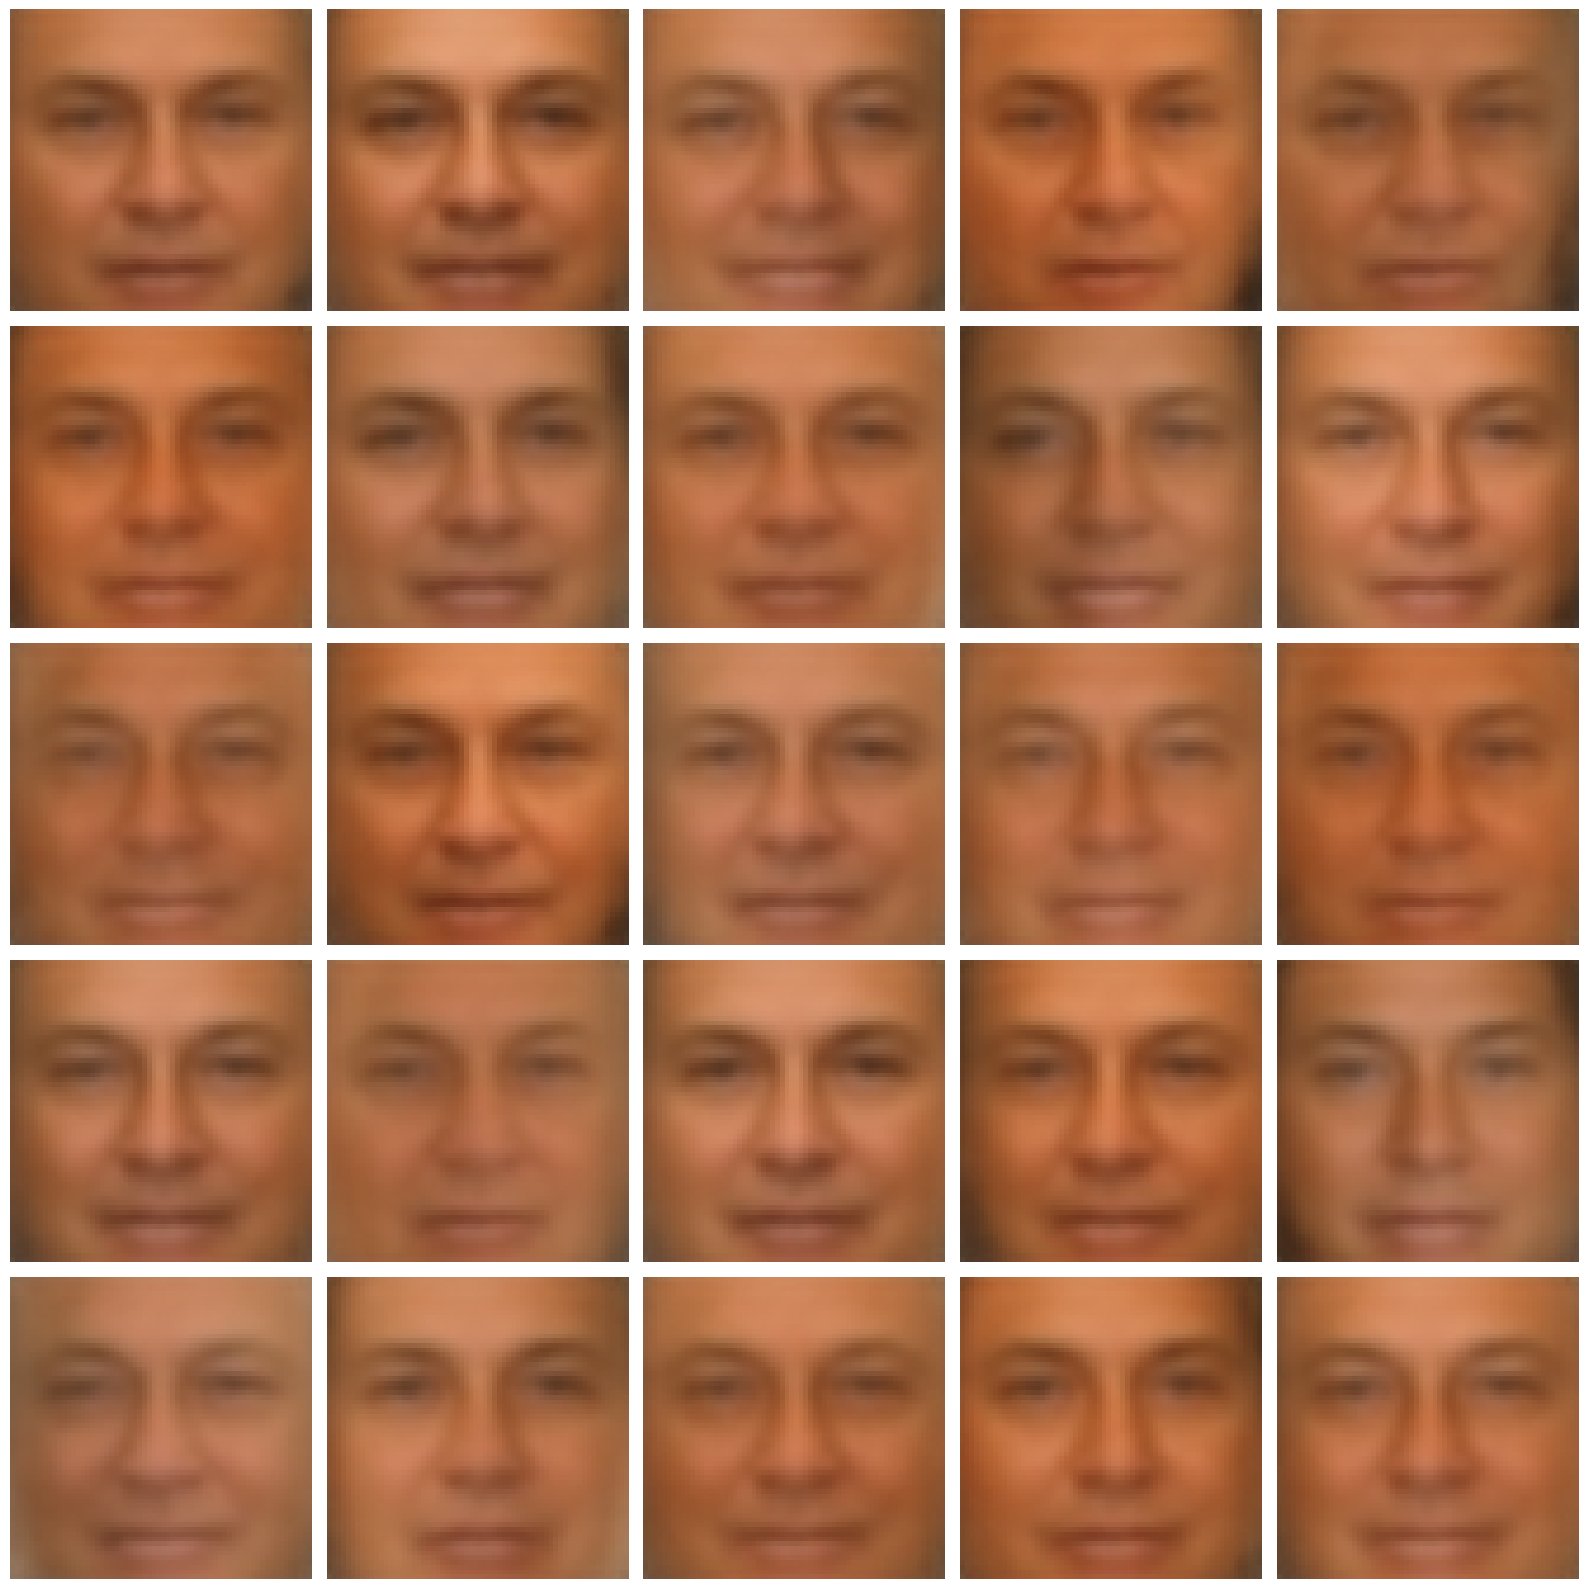

In [24]:
# создадим 25 случайных векторов размера latent_space
z = torch.randn(25, latent_space_dim).to(device) * latent_std + latent_mean
# <выведите тут полученные картинки>
fig, axes = plt.subplots(5, 5, figsize=(16, 16), tight_layout=True)
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        latent = z[idx].unsqueeze(0)
        output = model.decoder(latent)
        image = output.squeeze().permute(1, 2, 0).cpu().detach()
        axes[i, j].imshow(image)
        axes[i, j].axis("off")

plt.show();

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [25]:
# Для лучшей демонстративности возьмём только (преимущественно) женские лица,
# так как в наборе данных среди самых счастливых только женщины,
# а среди грустных – мужчины, что несколько искажает результаты
women = attrs.Male < 0
smiling_indeces = attrs[women].Smiling.astype(float).nlargest(15).index
sad_indeces = attrs[women].Smiling.astype(float).nsmallest(15).index

#### Посмотрим на звериные оскалы счастливых людей... и соберём данные об их латентных векторах:

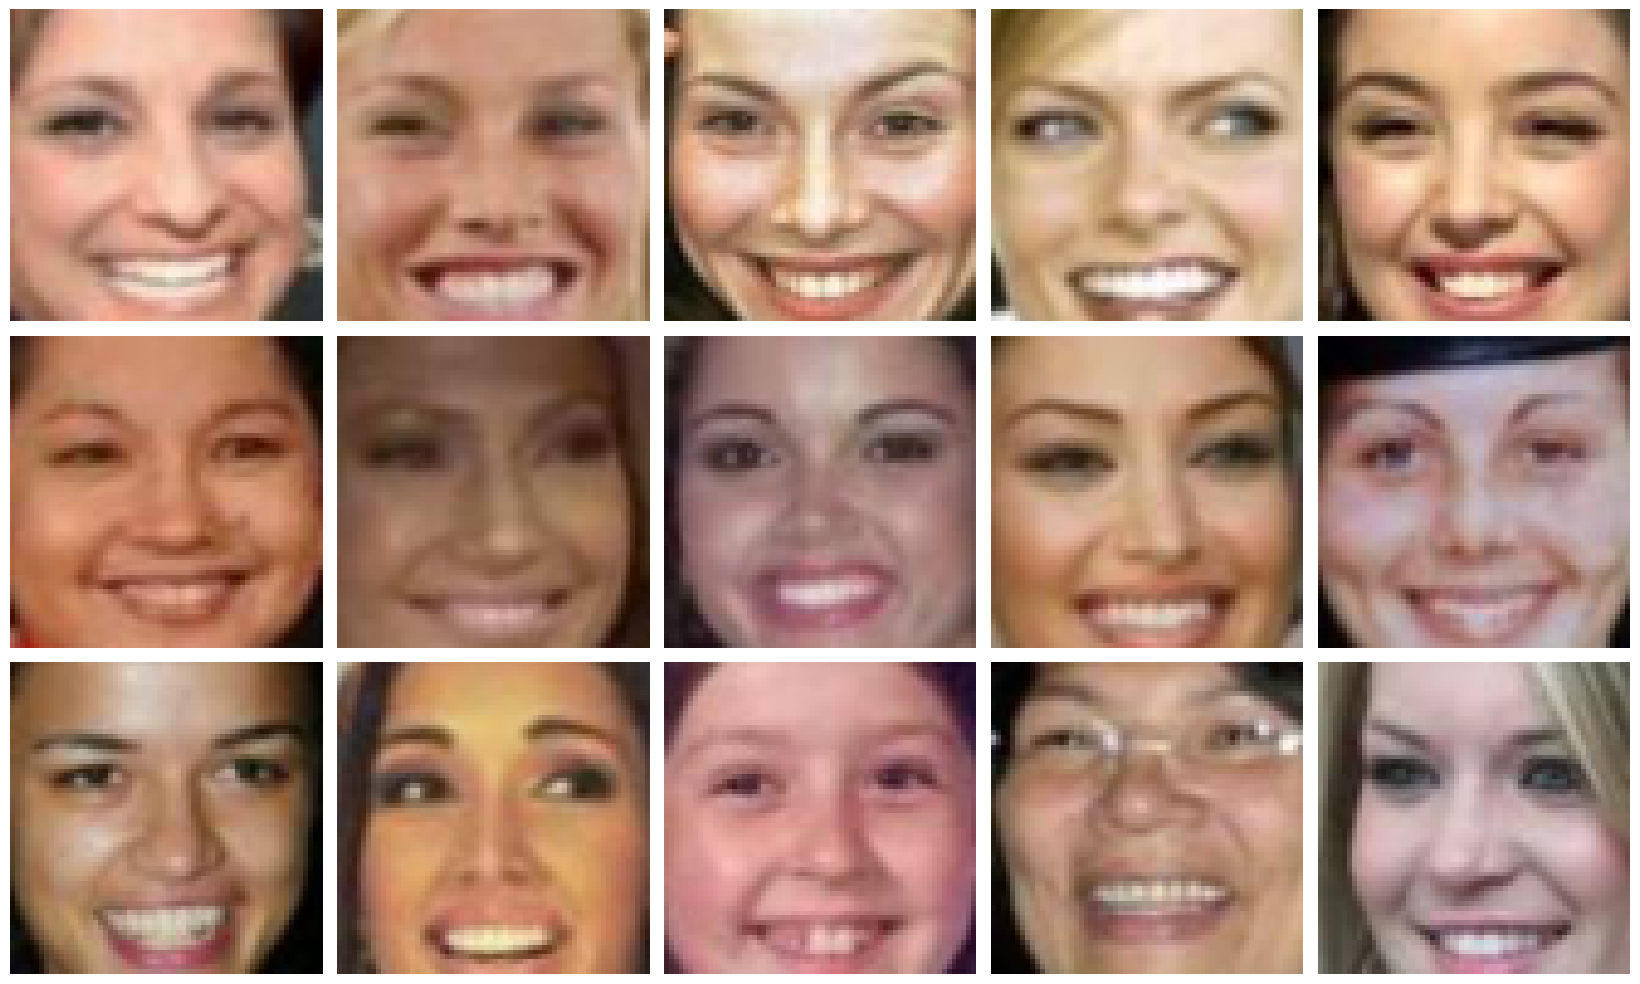

In [26]:
fig, axes = plt.subplots(3, 5, figsize=(16.5, 10), tight_layout=True)
smiling_faces = data[smiling_indeces]

smiling_latents = []
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        smiling_image = smiling_faces[idx].transpose(1, 2, 0)
        axes[i, j].imshow(smiling_image)
        axes[i, j].axis("off")

        latent = torch.from_numpy(smiling_image).float().to(device)
        smiling_latent = model.encoder(latent.permute(2, 0, 1).unsqueeze(0))
        smiling_latents.append(smiling_latent)

plt.show();

#### Теперь грустняшки...

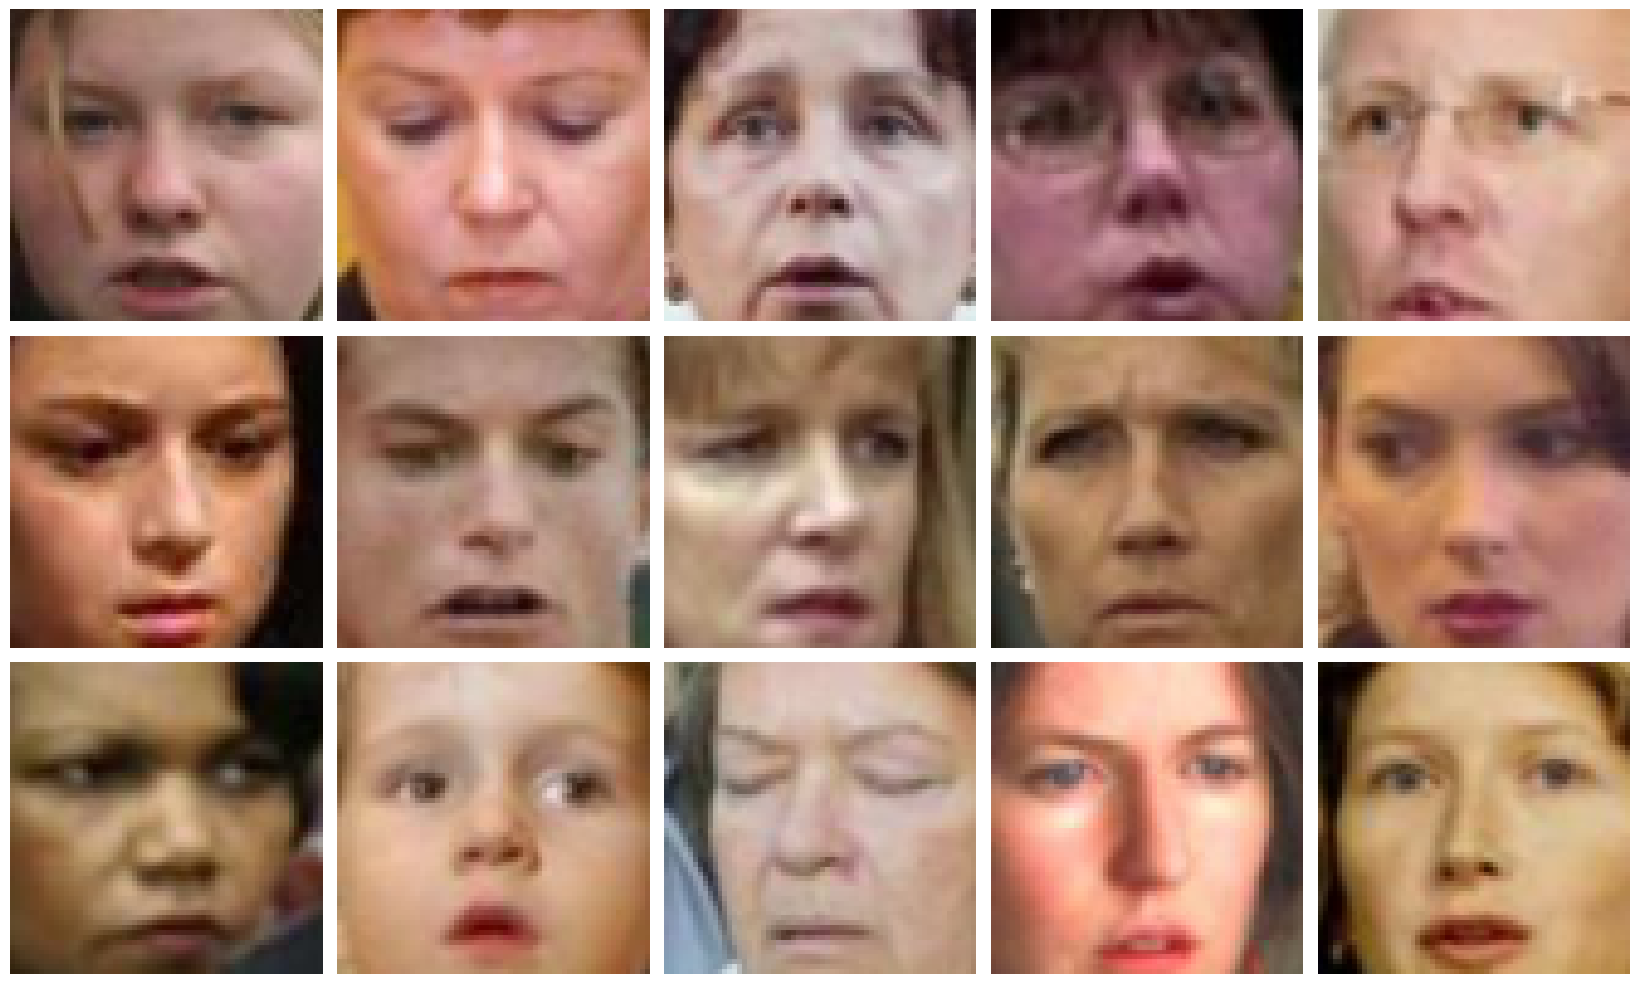

In [27]:
fig, axes = plt.subplots(3, 5, figsize=(16.5, 10), tight_layout=True)
sad_faces = data[sad_indeces]

sad_latents = []
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        sad_image = sad_faces[idx].transpose(1, 2, 0)
        axes[i, j].imshow(sad_image)
        axes[i, j].axis("off")

        torch_image = torch.from_numpy(sad_image).float().to(device)
        sad_latent = model.encoder(torch_image.permute(2, 0, 1).unsqueeze(0))
        sad_latents.append(sad_latent)

plt.show();

#### Вычислим веселящий вектор:

In [28]:
smiling_vector = torch.stack(smiling_latents).mean(0)
sad_vector = torch.stack(sad_latents).mean(0)

fun_vector = smiling_vector - sad_vector
fun_vector.shape

torch.Size([1, 256])

#### Прибавим его к латентным векторам грустняшек, несколько развеселив их:

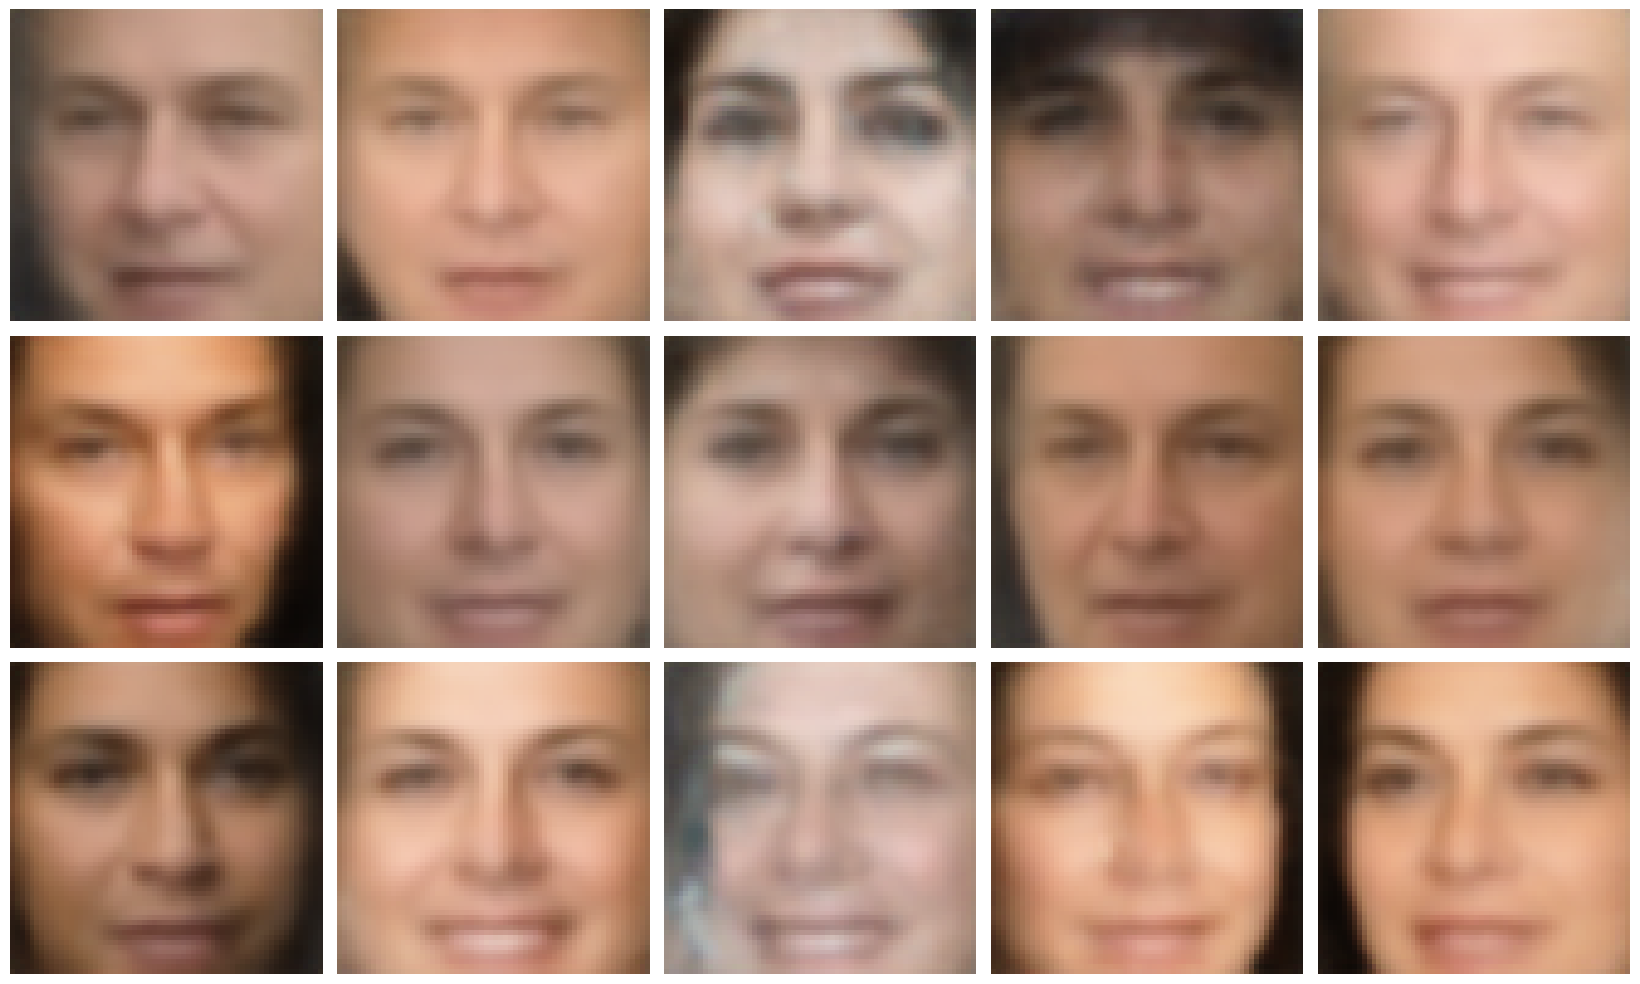

In [29]:
fig, axes = plt.subplots(3, 5, figsize=(16.5, 10), tight_layout=True)

for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        sad_latent = sad_latents[idx]
        latent = sad_latent + fun_vector
        output = model.decoder(latent)
        image = output.squeeze().permute(1, 2, 0).cpu().detach()
        axes[i, j].imshow(image)
        axes[i, j].axis("off")

plt.show();

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [9]:
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(
    root="./mnist_data/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="./mnist_data/", train=False, transform=transforms.ToTensor(), download=False
)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [15]:
picture = train_dataset[0][0]
picture.shape, picture.dtype

(torch.Size([1, 28, 28]), torch.float32)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [10]:
vae_latent_space_dim = 32

In [12]:
class VAE(nn.Module):
    def __init__(self, latent_space_dim=vae_latent_space_dim):
        super().__init__()
        self.latent_space_dim = latent_space_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.Flatten(),
            nn.Linear(8 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, self.latent_space_dim * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_space_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 8 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (8, 28, 28)),
            nn.ConvTranspose2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        latent = self.encoder(x)
        mu, log_var = latent.split(self.latent_space_dim, dim=1)

        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        if self.training:
            sample = torch.randn_like(mu)
            std = torch.exp(0.5 * log_var)
            return mu + sample * std
        else:
            return mu

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        sample = self.gaussian_sampler(mu, log_var)
        output = self.decode(sample)

        return mu, log_var, output

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = \log p_{\theta}(x|z) + D_{KL}\bigg\{q_{\phi}(z|x) || p(z)\bigg\}$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{\dim Z}\bigg[1+\log \sigma_i^2 -\mu_i^2-\sigma_i^2\bigg]$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [13]:
def kl_divergence(mu, log_var):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / 2


def loss_vae(x, mu, log_var, output):
    log_likelihood = F.binary_cross_entropy(output, x, reduction="sum")
    kl = kl_divergence(mu, log_var)
    loss = log_likelihood + kl

    return log_likelihood, kl, loss


mu.mean().item() = 0.006172403693199158
log_var.mean().item() = -0.05863998830318451
loglike.item() = 20700.734375
kl.item() = 43.56175231933594


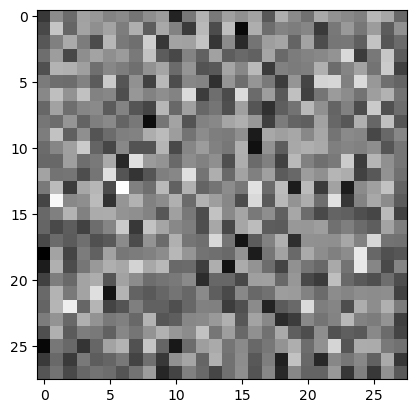

In [14]:
vae = VAE().to(device)
x, _ = next(iter(train_loader))
x = x.to(device)

mu, log_var, output = vae(x)
loglike, kl, train_loss = loss_vae(x, mu, log_var, output)
print(f"\n{mu.mean().item() = }")
print(f"{log_var.mean().item() = }")
print(f"{loglike.item() = }")
print(f"{kl.item() = }")
img = output.cpu().detach()[0, :, :].permute(1, 2, 0)
plt.imshow(img, cmap="gray")
# sns.heatmap(img)

In [15]:
mu.shape == (batch_size, vae_latent_space_dim)

True

И обучим модель:

In [16]:
criterion = loss_vae
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

In [17]:
# <обучите модель на датасете MNIST>
BEST_VAE_PATH = "best_vae.pt"
print(f"Using device: {device}")

n_epochs = 12

best_loss = float("inf")
best_epoch = 0

mnist_mus = []
mnist_log_vars = []

train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for batch, _ in train_loader:
        batch = batch.to(device)
        mu, log_var, output = model(batch)

        if epoch == n_epochs - 1:
            mnist_mus.append(mu)
            mnist_log_vars.append(log_var)

        loglike, kl, train_loss = criterion(batch, mu, log_var, output)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_per_epoch.append(train_loss.item())

    with torch.no_grad():
        epoch_train_loss = np.mean(train_losses_per_epoch)
        train_losses.append(epoch_train_loss)

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)

            mu, log_var, output = model(X_batch)
            loglike, kl, val_loss = criterion(X_batch, mu, log_var, output)

            val_losses_per_epoch.append(val_loss.item())

    with torch.no_grad():
        epoch_val_loss = np.mean(val_losses_per_epoch)
        val_losses.append(epoch_val_loss)

    scheduler.step()

    print(
        f"epoch {epoch} \t| train_loss: {epoch_train_loss:.4f}"
        f"\tval_loss: {epoch_val_loss:.4f}"
        f"\tloglike: {loglike.item():.4f}"
        f"\tkl: {kl.item():.4f}"
        + ("\t✡ new minimum, model saved." if epoch_val_loss < best_loss else "")
    )
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_epoch = epoch
        torch.save(model, BEST_VAE_PATH)

    # train_loss: 2685.7389	val_loss: 3156.2754	loglike: 1405.4553	kl: 154.5027

Using device: mps


  0%|          | 0/12 [00:00<?, ?it/s]

epoch 0 	| train_loss: 4383.4674	val_loss: 3410.9176	loglike: 1234.8625	kl: 324.6282	✡ new minimum, model saved.
epoch 1 	| train_loss: 3579.6673	val_loss: 3262.7269	loglike: 1188.7971	kl: 344.1713	✡ new minimum, model saved.
epoch 2 	| train_loss: 3459.6109	val_loss: 3184.2163	loglike: 1112.2505	kl: 356.4984	✡ new minimum, model saved.
epoch 3 	| train_loss: 3398.8084	val_loss: 3150.5144	loglike: 1083.1821	kl: 362.6827	✡ new minimum, model saved.
epoch 4 	| train_loss: 3363.3763	val_loss: 3119.2058	loglike: 1104.0090	kl: 353.8129	✡ new minimum, model saved.
epoch 5 	| train_loss: 3331.2754	val_loss: 3104.3274	loglike: 1084.4644	kl: 355.7950	✡ new minimum, model saved.
epoch 6 	| train_loss: 3309.9550	val_loss: 3070.2811	loglike: 1056.5610	kl: 359.6056	✡ new minimum, model saved.
epoch 7 	| train_loss: 3292.8173	val_loss: 3056.1143	loglike: 1060.2019	kl: 361.2621	✡ new minimum, model saved.
epoch 8 	| train_loss: 3275.6835	val_loss: 3043.3427	loglike: 1054.8894	kl: 357.7091	✡ new minim

In [18]:
vae = torch.load(BEST_VAE_PATH, weights_only=False)
vae.eval();

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

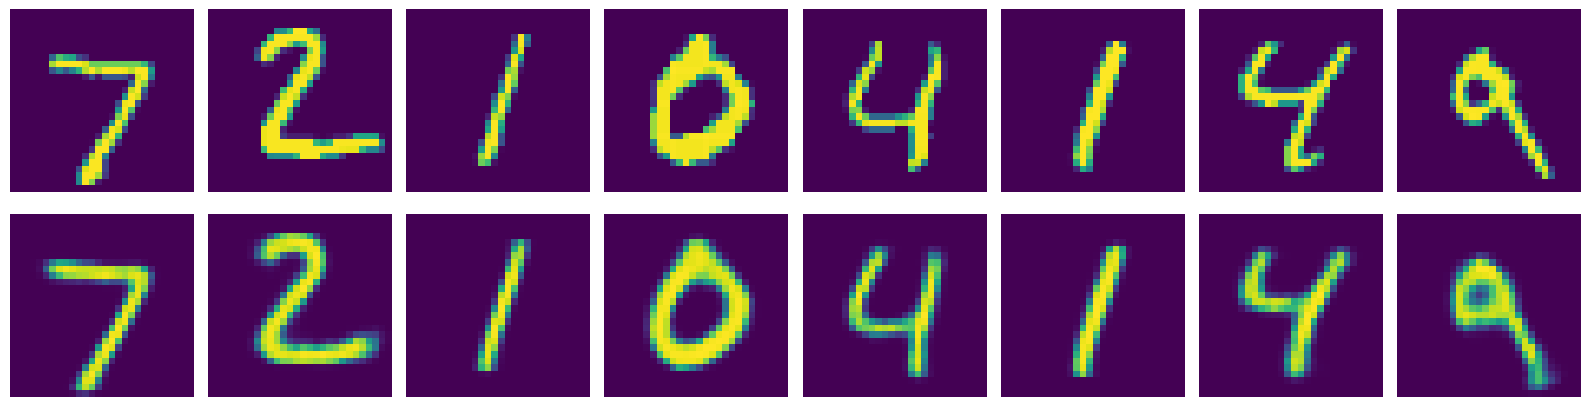

In [19]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 8, figsize=(16, 4.5), tight_layout=True)
for j in range(8):
    image_data, _ = test_dataset[j]
    image = image_data.permute(1, 2, 0)
    axes[0, j].imshow(image.numpy())
    axes[0, j].axis("off")
    _, _, output = vae(image_data.unsqueeze(0).to(device))
    output = output.squeeze().cpu().detach()
    axes[1, j].imshow(output)
    axes[1, j].axis("off")

plt.show();

In [20]:
mnist_mu = torch.vstack(mnist_mus).to(device).mean(0)
mnist_std = torch.vstack(mnist_log_vars).to(device).div(2).mean(0).exp()
mnist_mu, mnist_std

(tensor([ 3.7211e-03, -1.5780e-04,  2.0047e-02, -2.1977e-02,  6.0912e-05,
          2.2210e-04,  1.8420e-05,  1.5183e-02, -3.8454e-03,  3.9534e-04,
         -1.2042e-05, -1.8844e-04, -3.6656e-04,  1.5187e-02,  5.0291e-05,
          1.5581e-02, -2.5416e-04,  4.6708e-06, -9.9468e-03,  3.2379e-04,
         -3.5154e-04, -2.0163e-04, -8.6275e-03,  6.9867e-05, -6.6399e-05,
          7.1192e-04,  6.4208e-03, -2.4217e-04,  4.4663e-03, -4.8811e-06,
         -4.1463e-03, -1.7736e-02], device='mps:0', grad_fn=<MeanBackward1>),
 tensor([0.4713, 0.9975, 0.1592, 0.1614, 0.9975, 0.9975, 0.9973, 0.1138, 0.4371,
         0.9974, 0.9974, 0.9975, 0.9973, 0.1935, 0.9976, 0.2158, 0.9974, 0.9974,
         0.0939, 0.3731, 0.9975, 0.9973, 0.3666, 0.9973, 0.9975, 0.3236, 0.2079,
         0.9974, 0.2533, 0.9973, 0.3072, 0.1128], device='mps:0',
        grad_fn=<ExpBackward0>))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

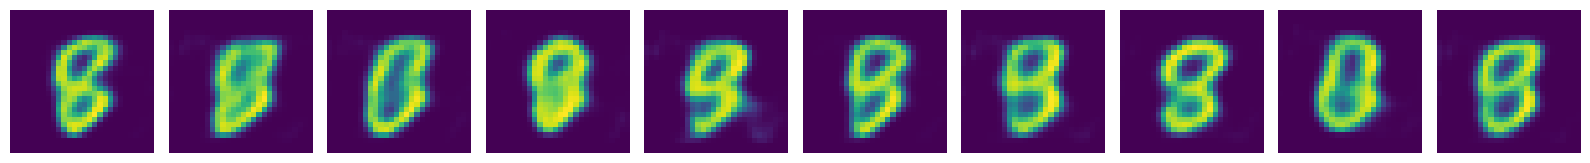

In [50]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.randn(10, vae_latent_space_dim, device=device)
z = z * mnist_std + mnist_mu

# output = <скормите z декодеру>
with torch.no_grad():
    output = vae.decoder(z)

# <выведите тут полученные картинки>
fig, axes = plt.subplots(1, 10, figsize=(16, 4.5), tight_layout=True)
for j in range(len(output)):
    image = output[j].permute(1, 2, 0).cpu().numpy()
    axes[j].imshow(image)
    axes[j].axis("off")

plt.show();

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [51]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
LIMIT = 10000

images, labels = list(zip(*test_dataset))
data = torch.vstack(images[:LIMIT]).unsqueeze(1).to(device)
labels = labels[:LIMIT]

In [52]:
from sklearn.manifold import TSNE

latent_vectors = vae.encode(data)[0].cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
latent_vectors_3d = tsne.fit_transform(latent_vectors)

((10000, 2),)

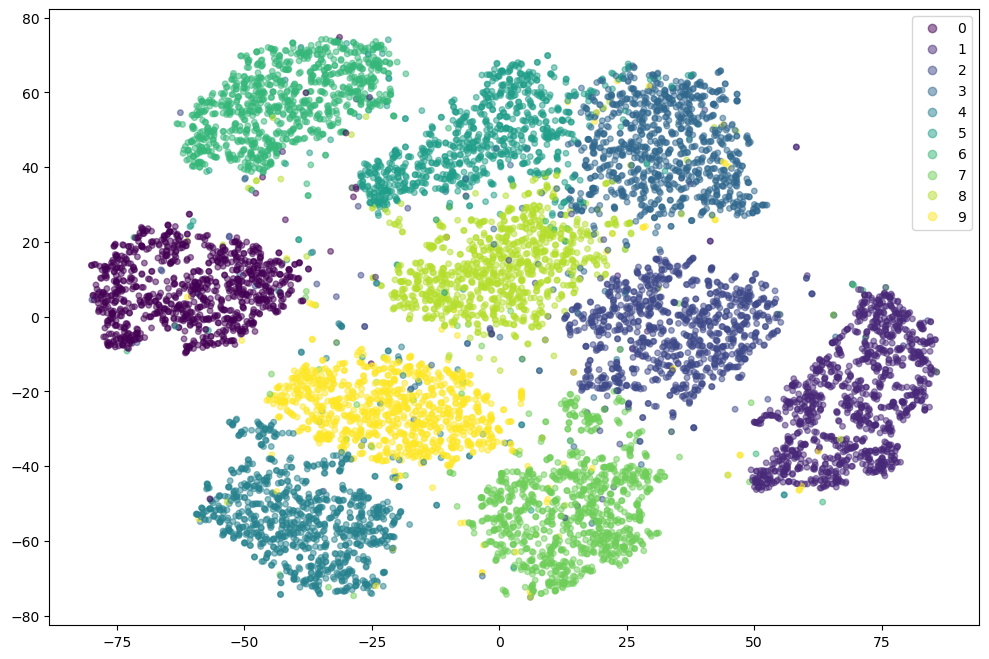

In [53]:
import plotly.express as px

# Plotly
fig = px.scatter_3d(
    x=latent_vectors_3d[:, 0],
    y=latent_vectors_3d[:, 1],
    z=latent_vectors_3d[:, 2],
    color=labels,
    opacity=0.5,
    title="Latent Space Visualization",
)
fig.update_layout(
    width=1000,
    height=800,
)
fig.update_traces(marker=dict(size=2))
fig.show()

# Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    latent_vectors_2d[:, 0],
    latent_vectors_2d[:, 1],
    c=labels,
    alpha=0.5,
    s=16,
)
plt.legend(*scatter.legend_elements(), loc="best")
plt.show()

Что вы думаете о виде латентного представления?

– Кластеры хорошо различимы и достаточны плотны сбиты. Не говоря уже про ошеломляющий эстетический эффект от увиденного.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [1]:
cvae_latent_space_dim = 32
label_dim = 10

In [3]:
class CVAE(nn.Module):
    def __init__(
        self,
        latent_space_dim=cvae_latent_space_dim,
        label_dim=label_dim,
    ):
        super().__init__()
        self.latent_space_dim = latent_space_dim
        self.label_dim = label_dim

        self.feature_encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.Flatten(),
        )
        self.main_encoder = nn.Sequential(
            nn.Linear(self.label_dim + 8 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, self.latent_space_dim * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_space_dim + self.label_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 8 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (8, 28, 28)),
            nn.ConvTranspose2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x, label):
        features = self.feature_encoder(x)
        labeled_features = torch.concat([features, label], dim=1)
        latent = self.main_encoder(labeled_features)
        mu, log_sigma = latent.split(self.latent_space_dim, dim=1)

        return mu, log_sigma

    def gaussian_sampler(self, mu, log_sigma):
        if self.training:
            sample = torch.randn_like(mu)
            return mu + sample * log_sigma.exp()
        else:
            return mu

    def decode(self, z, label):
        labeled_z = torch.concat([z, label], dim=1)
        return self.decoder(labeled_z)

    def forward(self, x, label):
        mu, log_sigma = self.encode(x, label)
        sample = self.gaussian_sampler(mu, log_sigma)
        output = self.decode(sample, label)

        return mu, log_sigma, output

NameError: name 'nn' is not defined

In [47]:
x, labels = next(iter(train_loader))
labels[:10], F.one_hot(labels[:10])

(tensor([5, 5, 7, 0, 4, 8, 2, 5, 2, 8]),
 tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]]))

In [48]:
BEST_CVAE_PATH = "best_cvae.pt"

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = loss_vae

print(f"Using device: {device}")

n_epochs = 16

best_loss = float("inf")
best_epoch = 0
mnist_mus = []
mnist_log_vars = []
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for batch, labels in train_loader:
        batch = batch.to(device)
        one_hot_labels = F.one_hot(labels, num_classes=label_dim).to(device)

        mu, log_var, output = model(batch, one_hot_labels)

        if epoch == n_epochs - 1:
            mnist_mus.append(mu)
            mnist_log_vars.append(log_var)

        loglike, kl, train_loss = criterion(batch, mu, log_var, output)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_per_epoch.append(train_loss.item())

    epoch_train_loss = np.mean(train_losses_per_epoch)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, labels in train_loader:
            batch = batch.to(device)
            one_hot_labels = F.one_hot(labels, num_classes=label_dim).to(device)

            mu, log_var, output = model(batch, one_hot_labels)
            loglike, kl, val_loss = criterion(batch, mu, log_var, output)

            val_losses_per_epoch.append(val_loss.item())

    epoch_val_loss = np.mean(val_losses_per_epoch)
    val_losses.append(epoch_val_loss)

    scheduler.step()

    print(
        f"epoch {epoch} \t| train_loss: {epoch_train_loss:.4f}"
        f"\tval_loss: {epoch_val_loss:.4f}"
        + ("\t✡ new minimum, model saved." if epoch_val_loss < best_loss else "")
    )
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_epoch = epoch
        torch.save(model, BEST_CVAE_PATH)

Using device: mps


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 0 	| train_loss: 4019.3190	val_loss: 3587.7053	✡ new minimum, model saved.
epoch 1 	| train_loss: 2930.8020	val_loss: 3414.5202	✡ new minimum, model saved.
epoch 2 	| train_loss: 2770.2786	val_loss: 3304.0838	✡ new minimum, model saved.
epoch 3 	| train_loss: 2690.1628	val_loss: 3171.2156	✡ new minimum, model saved.
epoch 4 	| train_loss: 2636.5194	val_loss: 2977.5175	✡ new minimum, model saved.
epoch 5 	| train_loss: 2599.0159	val_loss: 2992.1577
epoch 6 	| train_loss: 2571.0480	val_loss: 2909.0439	✡ new minimum, model saved.
epoch 7 	| train_loss: 2550.8050	val_loss: 2886.9070	✡ new minimum, model saved.
epoch 8 	| train_loss: 2535.7669	val_loss: 2923.2596
epoch 9 	| train_loss: 2524.3565	val_loss: 2908.4641
epoch 10 	| train_loss: 2514.2891	val_loss: 2854.5056	✡ new minimum, model saved.
epoch 11 	| train_loss: 2506.7252	val_loss: 2862.9019
epoch 12 	| train_loss: 2499.7283	val_loss: 2806.2121	✡ new minimum, model saved.
epoch 13 	| train_loss: 2495.1371	val_loss: 2828.6609
ep

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [49]:
mnist_mu = torch.vstack(mnist_mus).to(device).mean(0)
mnist_std = torch.vstack(mnist_log_vars).to(device).mean(0).exp()

In [50]:
cvae = torch.load(BEST_CVAE_PATH, weights_only=False).to(device)
cvae.eval();

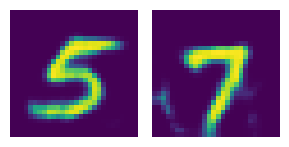

In [389]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
z = torch.randn(cvae_latent_space_dim).to(device).expand(2, -1)
z = z * mnist_std + mnist_mu

with torch.no_grad():
    one_hot_5 = F.one_hot(torch.tensor([5]), num_classes=10).to(device)
    one_hot_7 = F.one_hot(torch.tensor([7]), num_classes=10).to(device)
    one_hots = torch.concat([one_hot_5, one_hot_7])
    labeled_features = torch.concat([z, one_hots], dim=1)
    output = cvae.decoder(labeled_features)

# <выведите тут полученные картинки>
fig, axes = plt.subplots(1, 2, figsize=(3, 3), tight_layout=True)
for j in range(len(output)):
    image = output[j].permute(1, 2, 0).cpu().numpy()
    axes[j].imshow(image)
    axes[j].axis("off")

plt.show();

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [52]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
LIMIT = 10_000

images, labels = list(zip(*test_dataset))
image_data = torch.vstack(images[:LIMIT]).unsqueeze(1).to(device)
label_data = F.one_hot(torch.tensor(labels[:LIMIT])).to(device)

In [53]:
latent_vectors = cvae.encode(image_data, label_data)[0].cpu().detach().numpy()
latent_vectors_2d = tsne.fit_transform(latent_vectors)

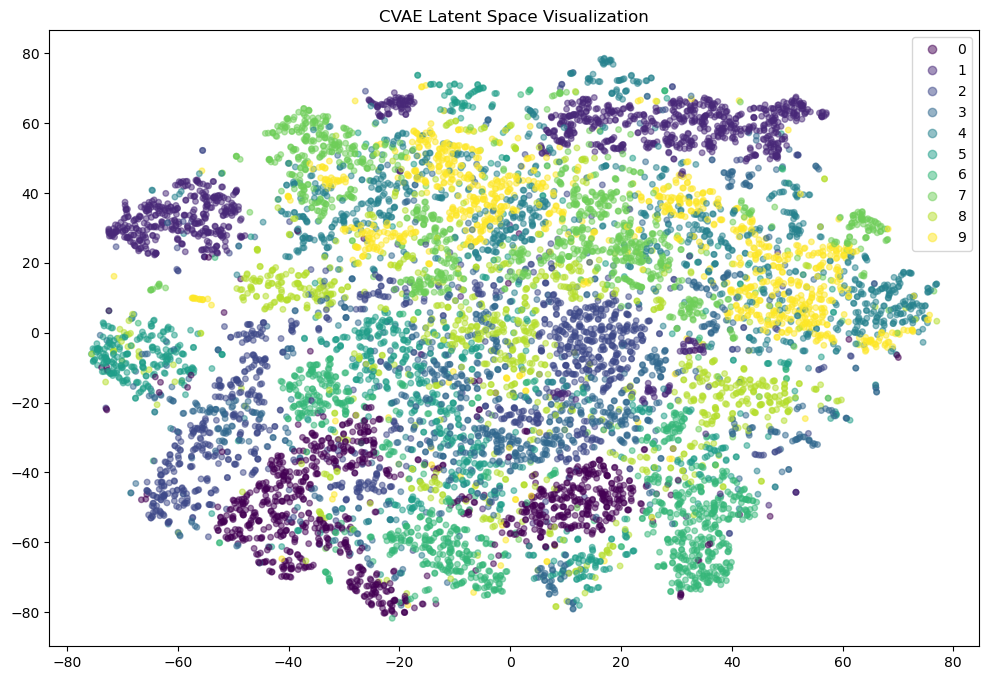

In [54]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    latent_vectors_2d[:, 0],
    latent_vectors_2d[:, 1],
    c=labels[:LIMIT],
    alpha=0.5,
    s=16,
)
plt.legend(*scatter.legend_elements(), loc="best")
plt.title("CVAE Latent Space Visualization")
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

– Отличия очевидны: у CVAE кластеры латентного пространства сильнее разобщены, сама же карта намного более однородна, за исключением отдельных небольших участков, по крайней мере в этом двумерном представлении.

# Все задания на очки сделаны, бонусы оставляю на потом, так как приболел, и голова работает плохо. Прошу отнестись с пониманием.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>


# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
# codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest

# lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей

    # code = <получение латентного представления image>

    # (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

    # return distances, X_train[idx]
    ...

In [ ]:
def show_similar(image):
    # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances, neighbors = get_similar(image, n_neighbors=11)

    plt.figure(figsize=[8, 6])
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().numpy().transpose([1, 2, 0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3, 4, i + 2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1, 2, 0]))
        plt.title("Dist=%.3f" % distances[i])
    plt.show()

In [ ]:
# <тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>